# Modélisation pour les émissions de gaz CO2    

       



# 1. Preliminary


##  1.1 Context

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non résidentiels. Des relevés ont été faits en 2016 mais le coût est important. 
Dès lors nous allons,à partir de ces relevés, mettre en place un modèle de prédiction des émissions de gaz à effet de serre et de consommation d’énergie des bâtiments pour lesquels les mesures n'ont pas encore été faites.

## 1.2 Requirements

Pandas
numpy

scikit-learn

matplotlib\
seaborn

In [1]:
package_list=("pandas","numpy","matplotlib","scikit-learn","seaborn")

In [2]:
!python3 -V

Python 3.9.13


In [3]:
txt=!python -m pip freeze
check = lambda i :any([(pack in i) for pack in package_list])
txt=[i for i in txt if check(i)]
txt

['-atplotlib @ file:///C:/ci/matplotlib-suite_1613408055530/work',
 'matplotlib==3.7.1',
 'numpy @ file:///C:/ci/numpy_and_numpy_base_1618497418457/work',
 'numpydoc @ file:///tmp/build/80754af9/numpydoc_1605117425582/work',
 'pandas @ file:///C:/ci/pandas_1618365634936/work',
 'scikit-learn @ file:///C:/b/abs_7ck_bnw91r/croot/scikit-learn_1676911676133/work',
 'seaborn @ file:///tmp/build/80754af9/seaborn_1608578541026/work']

## 1.3 Imports

In [4]:
# builtin
import os,warnings,sys

# data
import pandas as pd
import numpy as np



# visualisation
import matplotlib as mtpl
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler,RobustScaler


#estimators
import sklearn
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR, LinearSVR

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor  


from sklearn.neighbors import KNeighborsRegressor

# model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.pipeline import Pipeline

from sklearn import set_config
set_config(display='diagram') 

import time



#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import r_regression,f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

# metrics
from sklearn.metrics import r2_score,mean_absolute_percentage_error,  mean_absolute_error, mean_squared_error



from pprint import pprint

In [5]:
def score(estimator):
    """compute and print train score and test score"""
    tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} score_test : {te_score} ")
    

In [6]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

In [7]:
@timeit
def regression(model,name,X_train,y_train):
    metrics = ['r2','neg_mean_absolute_error', 'neg_mean_squared_error']
    score = cross_validate(model,X,y,cv=10, scoring = metrics, return_train_score = True)
    
    dico = {
        'modèle ': [name],
        'Fit time': [score['fit_time'].mean()],
        'Durée': [score['score_time'].mean()],
        'Train R2': [score['train_r2'].mean()],
        'Test R2': [score['test_r2'].mean()],
        'Train RMSE': [np.sqrt(- (score['train_neg_mean_squared_error'].mean()))],
        'Test RMSE': [np.sqrt(- (score['test_neg_mean_squared_error'].mean()))],
        'Train MAE': [- (score['train_neg_mean_absolute_error'].mean())],
        'Test MAE': [- (score['test_neg_mean_absolute_error'].mean())]
         }
    df_dico = pd.DataFrame(dico)
    return df_dico

In [8]:
@timeit
def compare_resultat(X_train,y_train):
    resultats = pd.DataFrame()
    model =[]
    model.append(('Dummy_regressor',DummyRegressor()))
    model.append(('Linear_regression', linear_model.LinearRegression()))
    model.append(('Elastic net', ElasticNet(random_state=seed)))
    model.append(('Random_forest', RandomForestRegressor(random_state=seed)))
    model.append(('Bagging regressor',BaggingRegressor(random_state=seed)))
    model.append(('LinearSVR', LinearSVR(random_state=seed))),
    model.append(('KernelSVR', SVR(kernel='linear'))),
    model.append(('GradientBoostingRegressor',GradientBoostingRegressor(random_state=seed)))
    model.append(('Knn',  KNeighborsRegressor() ))
       
    for name, mod in model: 
        res = regression(mod, name,X_train,y_train)
        resultats = pd.concat([resultats,res], ignore_index=True)
    return resultats.style.hide_index()

In [9]:
@timeit
def gridCV(model, parameters,X_train,y_train, cv):
    model_grid= GridSearchCV(estimator = model,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=cv,
                        return_train_score = True
                          )
    model_grid.fit(X_train,y_train)
    return model_grid

In [10]:
@timeit
def resultats_grid(model_grid, name,X_train, y_train):
    #Récupération des paramètres de la grille. 
    cv_grid = pd.DataFrame(model_grid.cv_results_)
    
    y_pred = model_grid.predict(X_train)
    rmse= np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred))
    r2=sklearn.metrics.r2_score(y_train,y_pred)
    #creation d'un dataframe des résultats
    results = {
        'modèle': [name],
        'Fit time': [cv_grid['mean_fit_time'].mean()],
        'Score time': [cv_grid['mean_score_time'].mean()],
        #'Best score RMSE': [-(model_grid.best_score_)],
        'Mean train score RMSE': [-(cv_grid["mean_train_score"].mean())],
        'Mean test score RMSE' : [-(cv_grid["mean_test_score"].mean())],
        'Best estimator': [model_grid.best_params_],
        'RMSE best estimator':[rmse],
        #'R2 best estimator':[r2]
         }
    df_resultats = pd.DataFrame(results)

    return df_resultats

## 1.4 Graphics and options

In [11]:
# warnings.filterxarnings('ignore'ou once
warnings.filterwarnings(action='ignore')
# nous désactivons les messages d'erreur
pd.set_option('display.max_columns', 200)
# Versions
print('Version des librairies utilisées :')

print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Python                : ' + sys.version)
print('Matplotlib            : ' + mtpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)

Version des librairies utilisées :
NumPy                 : 1.20.1
Pandas                : 1.2.4
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Matplotlib            : 3.7.1
Seaborn               : 0.11.1
Sklearn               : 1.2.1


## 1.5 Data loading

In [12]:
os.listdir()

['.ipynb_checkpoints',
 'P4_1_Notebook_exploratoire.ipynb',
 'P4_consommation.ipynb',
 'P4_emission.ipynb']

In [13]:
path =('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P4\\cleaned\\')
filename='df_cleaned_p4.csv'   ## ou df_cleaned_p4.csv

In [14]:
data=pd.read_csv(path+filename)

# 2. Data preparation

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1534 non-null   object 
 1   PrimaryPropertyType              1534 non-null   object 
 2   Neighborhood                     1534 non-null   object 
 3   Latitude                         1534 non-null   float64
 4   Longitude                        1534 non-null   float64
 5   NumberofFloors                   1534 non-null   int64  
 6   LargestPropertyUseType           1534 non-null   object 
 7   LargestPropertyUseTypeGFA        1534 non-null   float64
 8   SecondLargestPropertyUseType     1534 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1534 non-null   float64
 10  ThirdLargestPropertyUseType      1534 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1534 non-null   float64
 12  ratio_parking       

Retirons les variables 'log_consommation'

In [16]:
data.drop(columns=['log_consommation'],inplace=True)

In [17]:
# la target est log_emission
df=data.copy()

### 2.1.1 X & y

In [18]:
seed=1234
X=df.drop(columns=['log_emission'])
y=df.log_emission

In [19]:
X.shape

(1534, 17)

In [20]:
X.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofFloors,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ratio_parking,Building_age,SteamUse_ratio,Electricity_ratio,NaturalGas_ratio
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,12,Hotel,88434.0,0,0.0,0,0.0,0.000000,89,0.277302,0.546060,0.176638
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,11,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,0.145453,20,0.000000,0.386609,0.613391
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,41,Hotel,756493.0,0,0.0,0,0.0,0.205748,47,0.297113,0.682307,0.020579
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,10,Hotel,61320.0,0,0.0,0,0.0,0.000000,90,0.325913,0.407519,0.266567
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,18,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,0.353115,36,0.000000,0.378802,0.621198


In [21]:
y.shape

(1534,)

In [22]:
X.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofFloors,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ratio_parking,Building_age,SteamUse_ratio,Electricity_ratio,NaturalGas_ratio
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,12,Hotel,88434.0,0,0.0,0,0.0,0.000000,89,0.277302,0.546060,0.176638
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,11,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,0.145453,20,0.000000,0.386609,0.613391
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,41,Hotel,756493.0,0,0.0,0,0.0,0.205748,47,0.297113,0.682307,0.020579
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,10,Hotel,61320.0,0,0.0,0,0.0,0.000000,90,0.325913,0.407519,0.266567
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,18,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,0.353115,36,0.000000,0.378802,0.621198


In [23]:
y.head()

0    2.399639
1    2.472552
2    3.320204
3    2.458532
4    2.704159
Name: log_emission, dtype: float64

### 2.1.2 Preprocessing  des variables du jeu de données avec transformers ScandardScaler et OneHotEncoder  

In [24]:
set_config(transform_output="pandas")

# on définit les colonnes et les transformations pour les colonnes quantitatives

col_quanti =  X.select_dtypes(['int64','float64']).columns

transfo_quanti = Pipeline(steps=[('standard', StandardScaler())])

# on définit les colonnes et les transformations pour les variables qualitatives

col_quali =  X.select_dtypes(['object']).columns

transfo_quali = Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False,drop="if_binary", handle_unknown="ignore"))])

# on définit l'objet de la classe ColumnTransformer qui va permettre  d'appliquer toutes les étapes

traitement = ColumnTransformer(
    transformers=[
        ('quanti', transfo_quanti , col_quanti),
        ('quali', transfo_quali , col_quali)])

### 2.1.3 Création d'un Pipeline et entrainement du modèle avec une régression RF

In [25]:
# on crée un pipeline  intégrant la préparation
modele_ml = Pipeline(steps=[('preprocessing', traitement),
                      ('rf', RandomForestRegressor(n_estimators=100, 
                                      random_state=seed, 
                                      verbose=0))])

# on construit les jeux d'entrainement , de test et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.20,random_state=seed)

# on ajuste le modèle en utilisant les données d'apprentissage
# le modèle comporte la préparation et le modèle logistique
modele_ml.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quanti',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  Index(['Latitude', 'Longitude', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ratio_parking', 'Building_age', 'SteamUse_ratio', 'Electricity_ratio',
       'NaturalGas_ratio'],
      dtype='object')),
                                                 ('quali',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType'],
      dtype='object'))])),
                ('rf', RandomForestRegressor(random_state=1234))])

In [26]:
y_pred=modele_ml.predict(X_test)

In [27]:
# afficher les scores du modele
score(modele_ml)

score train : 0.9688 score_test : 0.7949 


> essayons d'améliorer le score 

### 2.1.4 Recherche des meilleurs paramètres avec GridSearchCV

In [28]:
# on définit les paramètres à faire varier
param_grid = {
    'rf__n_estimators': [100,250,500],
'rf__max_features':["sqrt","log2","None"],
'rf__max_depth':[None,5],
'rf__max_leaf_nodes': [None,10],}

# on crée le modèle de grille
grid_search = GridSearchCV(modele_ml, param_grid, cv=5)
# on ajuste aux données d'apprentissage
grid_search.fit(X_train, y_train)


print(("Le meilleur modèle logistique a obtenu sur les données test la performance suivante : %.2f"
       % grid_search.score(X_test, y_test)))
print('les meilleurs paramètres sont :',grid_search.best_params_)

Le meilleur modèle logistique a obtenu sur les données test la performance suivante : 0.78
les meilleurs paramètres sont : {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': None, 'rf__n_estimators': 250}


> On va entrainer le modèle avec les meilleurs hyper-paramètres

In [29]:

modele_ml = Pipeline(steps=[('preprocessing', traitement),
                      ('rf', RandomForestRegressor(max_depth= None, max_features= 'sqrt', max_leaf_nodes= None, n_estimators= 250
                                      ,random_state=seed, 
                                      verbose=0))])


# on ajuste le modèle en utilisant les données d'apprentissage

modele_ml.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quanti',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  Index(['Latitude', 'Longitude', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ratio_parking', 'Building_age', 'SteamUse_ratio', 'Electricity_ratio',
       'NaturalGas_ratio...
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType'],
      dtype='object'))])),
                ('rf',
                 RandomForestRegressor(max_features='sqrt', n_estimators=250,
                                       random_state=1234))])

In [30]:
y_pred=modele_ml.predict(X_test)

In [31]:
score(modele_ml)

score train : 0.9673 score_test : 0.7811 


> nous n'avons pas amélioré les performances du modèle :  

        avant tuning des hyper-paramètres :    score train : 0.9688 et score_test : 0.7949
        après tuning des hyper-paramètres :    score train : 0.9673 et score_test : 0.7811         

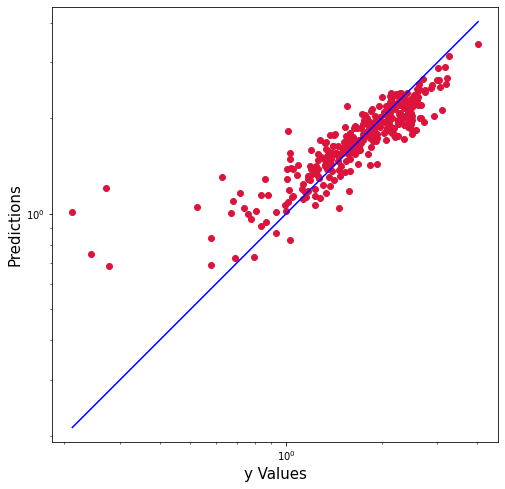

In [32]:
y_pred=modele_ml.predict(X_test)
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 2.1.5 Importance des variables du dataset dans la regression RF

In [33]:
#  poids des variables de la regression RF à partir du modele pipeline
reg_rf = modele_ml[-1]
# crée un dataframe pandas
data = list(zip(reg_rf.feature_names_in_, reg_rf.feature_importances_*100))
df_importances = pd.DataFrame(data, columns=['Feature', '% Importance']).sort_values(by='% Importance', ascending=True)
df_importances.tail(20)

,Feature,% Importance
66,quali__LargestPropertyUseType_Hotel,0.734268
76,quali__LargestPropertyUseType_Office,0.743437
32,quali__PrimaryPropertyType_Supermarket / Groce...,0.866945
65,quali__LargestPropertyUseType_Hospital (Genera...,0.920181
140,quali__SecondLargestPropertyUseType_Parking,0.976517
21,quali__PrimaryPropertyType_Large Office,1.147315
34,quali__PrimaryPropertyType_Warehouse,1.243309
31,quali__PrimaryPropertyType_Small- and Mid-Size...,1.330296
6,quanti__ratio_parking,1.475826
75,quali__LargestPropertyUseType_Non-Refrigerated...,1.517569


<Axes: ylabel='Feature'>

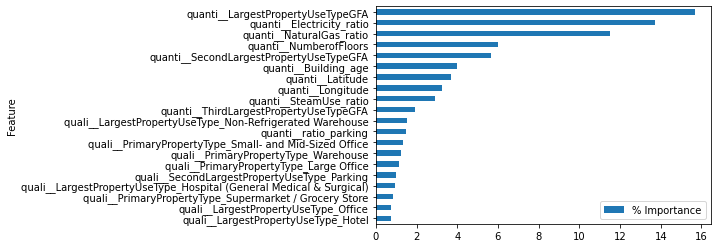

In [34]:
df_importances.tail(20).plot.barh(x='Feature', y='% Importance')

>pour la suite , je vais sélectionner les variables les plus pertinentes. Je commence par créer un dataframe avec les colonnes résultants du OneHotEncoder et duStandardScaler  


In [35]:
X[col_quanti] = transfo_quanti.fit_transform(X[col_quanti])
ohe=transfo_quali.fit_transform(X[col_quali])

In [36]:
X = pd.merge(X[col_quanti], 
          pd.DataFrame(columns = transfo_quali.get_feature_names_out().tolist(),
              data =ohe),
        left_index = True, right_index = True)

In [37]:
X.shape

(1534, 199)

### 2.1.6 Sélection des variables avec le transformer VarianceThresold (seuil de variance minimale en dessous duquel les variables ne sont pas conservées)

calculons les variances des variables de X

In [38]:
# calculer les variances
X.var(axis=0).describe()

count    199.000000
mean       0.074916
std        0.227906
min        0.000652
25%        0.001303
50%        0.005191
75%        0.026030
max        1.000652
dtype: float64

Eliminons les variables qui ont une variance inférieure au seuil fixé (seuil fixé = mean )

In [39]:
# on crée le selector
selector = VarianceThreshold(threshold =X.var(axis=0).mean())

#on entraine et transforme
X_thres=selector.fit_transform(X)


In [40]:
concol = [column for column in X.columns 
          if column not in X.columns[selector.get_support()]]

for features in concol:
    print(features)
print('nombre de colonnes:',len(concol))

BuildingType_Campus
BuildingType_NonResidential
BuildingType_Nonresidential COS
BuildingType_Nonresidential WA
BuildingType_SPS-District K-12
PrimaryPropertyType_Distribution Center
PrimaryPropertyType_Hospital
PrimaryPropertyType_Hotel
PrimaryPropertyType_K-12 School
PrimaryPropertyType_Laboratory
PrimaryPropertyType_Medical Office
PrimaryPropertyType_Mixed Use Property
PrimaryPropertyType_Refrigerated Warehouse
PrimaryPropertyType_Residence Hall
PrimaryPropertyType_Restaurant
PrimaryPropertyType_Retail Store
PrimaryPropertyType_Self-Storage Facility
PrimaryPropertyType_Senior Care Community
PrimaryPropertyType_Supermarket / Grocery Store
PrimaryPropertyType_University
PrimaryPropertyType_Worship Facility
Neighborhood_BALLARD
Neighborhood_Ballard
Neighborhood_CENTRAL
Neighborhood_Central
Neighborhood_DELRIDGE
Neighborhood_DELRIDGE NEIGHBORHOODS
Neighborhood_Delridge
Neighborhood_EAST
Neighborhood_NORTH
Neighborhood_NORTHEAST
Neighborhood_NORTHWEST
Neighborhood_North
Neighborhood_North

In [41]:
X.shape

(1534, 199)

In [42]:
X=X.drop(concol,axis=1)

In [43]:
X.shape

(1534, 25)

## 2.2 découpage de dataset avec le transformer Test_train_split

Je fais une division du jeu de données pour obtenir un jeu d'entrainement et un jeu de test

In [44]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.20,
                                                random_state=seed)

In [45]:
print(f"nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
      

nous avons X_train de forme (1227, 25) et y_train de forme (1227,)
Nous avons X_test de forme (307, 25) et y_test de forme (307,)


# 3. Modélisation

In [46]:
compare_resultat(X_train,y_train)

Durée d'exécution de regression: 0.03926348686218262s
Durée d'exécution de regression: 0.15689849853515625s
Durée d'exécution de regression: 0.11638045310974121s
Durée d'exécution de regression: 15.786562442779541s
Durée d'exécution de regression: 1.6817293167114258s
Durée d'exécution de regression: 0.4327864646911621s
Durée d'exécution de regression: 5.1085803508758545s
Durée d'exécution de regression: 6.447895288467407s
Durée d'exécution de regression: 0.9699411392211914s
Durée d'exécution de compare_resultat: 31.804523944854736s


modèle,Fit time,Durée,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
Dummy_regressor,0.001221,0.000933,0.000000,-0.296795,0.625876,0.640626,0.495263,0.507557
Linear_regression,0.007541,0.003539,0.627702,0.465680,0.381708,0.406679,0.302185,0.320838
Elastic net,0.004335,0.003450,0.000000,-0.296795,0.625876,0.640626,0.495263,0.507557
Random_forest,1.532295,0.014273,0.965825,0.666710,0.115647,0.321628,0.086953,0.243842
Bagging regressor,0.156769,0.004287,0.951941,0.629923,0.137157,0.338484,0.098097,0.258309
LinearSVR,0.036669,0.003092,0.609514,0.421488,0.390903,0.422792,0.297947,0.323498
KernelSVR,0.446604,0.008994,0.611478,0.421186,0.389928,0.422601,0.298992,0.322587
GradientBoostingRegressor,0.630595,0.006061,0.851021,0.688639,0.241415,0.311180,0.183666,0.237307
Knn,0.003608,0.045223,0.719935,0.430732,0.331037,0.422623,0.257103,0.329739


### 3.0 Dummy Regressor

In [47]:
dr=DummyRegressor(strategy='mean')
dr.fit(X_train,y_train)
score(dr)

score train : 0.0 score_test : -0.0016 


 

### 3.1  Régression linéaire

In [48]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [49]:
params={'fit_intercept' :[True,False]}

In [50]:
lr_grid = gridCV(lr, params, X_train, y_train,10)

Durée d'exécution de gridCV: 0.2894277572631836s


In [51]:
optimisation = resultats_grid(lr_grid, "Linear regression",X_train, y_train)


Durée d'exécution de resultats_grid: 0.014221429824829102s


### 3.2 Elastic Net

In [52]:
eln=ElasticNet(alpha=0.001, l1_ratio=0.5,random_state=seed)
eln.fit(X_train,y_train)

ElasticNet(alpha=0.001, random_state=1234)

In [53]:
y_pred=eln.predict(X_test)

In [54]:
score(eln)

score train : 0.621 score_test : 0.644 


In [55]:
regression(eln,'ElasticNet',X_train,y_train)

Durée d'exécution de regression: 0.21769428253173828s


,modèle,Fit time,Durée,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,ElasticNet,0.012685,0.004263,0.627451,0.471326,0.381837,0.404832,0.302611,0.320526


In [56]:
eln_parameters ={
    'alpha': np.arange(0.001,10, 0.1),
    'l1_ratio' : np.arange(0.0, 1, 0.1)
            }

In [57]:
eln_grid = gridCV(linear_model.ElasticNet(), eln_parameters, X_train, y_train,5)


Durée d'exécution de gridCV: 51.32789492607117s


In [58]:
optimi_eln = resultats_grid(eln_grid, "ElasticNet",X_train, y_train)
optimisation=pd.concat([optimisation,optimi_eln],ignore_index=True)
optimisation

Durée d'exécution de resultats_grid: 0.008725404739379883s


,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,Linear regression,0.006460,0.00379,0.523593,0.537759,{'fit_intercept': True},0.388209
1,ElasticNet,0.005324,0.00225,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506


In [59]:
eln=ElasticNet(alpha=0.401, l1_ratio=0.0,random_state=seed)
eln.fit(X_train,y_train)

ElasticNet(alpha=0.401, l1_ratio=0.0, random_state=1234)

In [60]:
score(eln)

score train : 0.568 score_test : 0.5883 


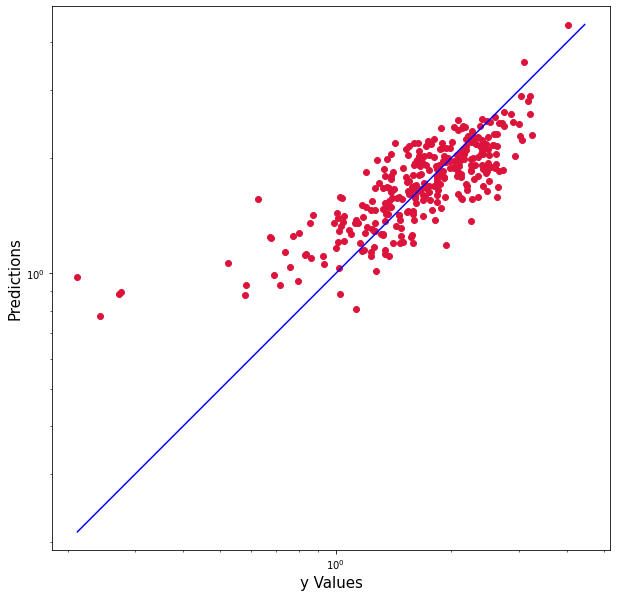

In [61]:
y_pred=eln_grid.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


### 3.3 Random forest  

In [62]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=1234)

In [63]:
y_pred=rf.predict(X_test)

In [64]:
score(rf)

score train : 0.9639 score_test : 0.7686 


In [65]:
regression(rf,'RandomForest',X_train,y_train)

Durée d'exécution de regression: 15.103153705596924s


,modèle,Fit time,Durée,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,RandomForest,1.467873,0.013381,0.965825,0.66671,0.115647,0.321628,0.086953,0.243842


In [66]:

#affichons les paramètres actuels de RandomForestRegressor
print('Paramètres actuels:\n')
pprint(rf.get_params())

Paramètres actuels:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


In [67]:

# nombre d'arbres dans random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Nombre de caractéristiques à prendre en compte à chaque split
max_features = ['auto', 'sqrt']
# Nombre maximum de branches dans l'arbre
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Nombre minimum d'échantillons nécessaire pour diviser
min_samples_split = [2, 5, 10]
# Nombre minimal d'échantillons requis à chaque nœud 
min_samples_leaf = [1, 2, 4,10]
# Méthode de sélection des échantillons pour l'entrainement de chaque arbre
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [68]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# entrainer le modele rf_random
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1234),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1234, verbose=2)

In [69]:
# affichons les meilleurs paramètres
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [70]:

# Créez la grille de paramètres basée sur les résultats de la recherche aléatoire 
random_parameters = { 
    'bootstrap': [True], 
    'max_depth': [35, 50, 45], 
    'max_features': ['sqrt'], 
    'min_samples_leaf' : [1], 
    'min_samples_split' : [3,5,7], 
    'n_estimators' : [1350,1400,1450] 
}


In [71]:
rf_grid = gridCV(RandomForestRegressor(), random_parameters,X_train, y_train,5)

Durée d'exécution de gridCV: 703.9131238460541s


In [72]:
optimi_rf=resultats_grid(rf_grid,'RandomForest',X_train,y_train)
optimisation=pd.concat([optimisation,optimi_rf],ignore_index=True)

Durée d'exécution de resultats_grid: 0.35309457778930664s


In [73]:
optimisation

,modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
0,Linear regression,0.006460,0.00379,0.523593,0.537759,{'fit_intercept': True},0.388209
1,ElasticNet,0.005324,0.00225,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
2,RandomForest,4.756468,0.14912,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_feat...",0.129093


In [74]:
score(rf_grid)

score train : -0.1291 score_test : -0.2887 


In [75]:
y_pred=rf_grid.predict(X_test)

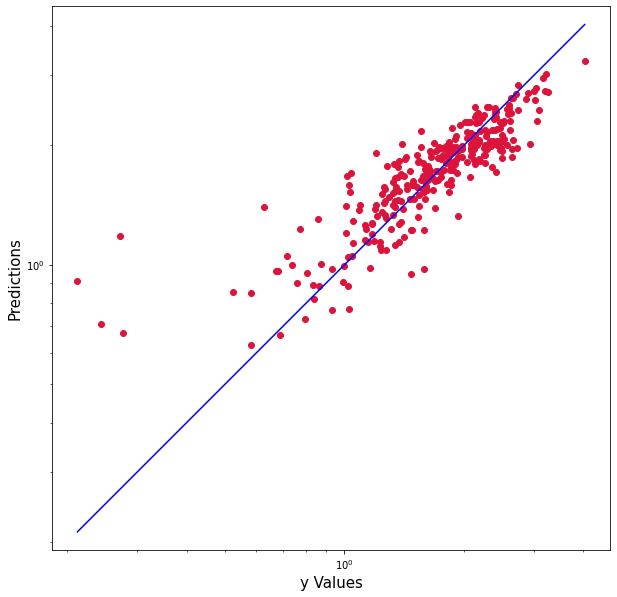

In [76]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 3.4 Bagging Regressor 

In [77]:
br=BaggingRegressor(n_estimators=50,random_state=seed)
br.fit(X_train,y_train)


BaggingRegressor(n_estimators=50, random_state=1234)

In [78]:
score(br)

score train : 0.9615 score_test : 0.7629 


In [79]:
regression(br,'BaggingRegressor',X_train,y_train)

Durée d'exécution de regression: 7.571630477905273s


,modèle,Fit time,Durée,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,BaggingRegressor,0.725646,0.009711,0.964281,0.66323,0.118229,0.322988,0.088293,0.244432


In [80]:
n_samples = X.shape[0]
n_features = X.shape[1]
bagging_parameters = { 
    'n_estimators': [20,50,100],
          'max_samples': [0.5,1.0, n_samples//2,],
          'max_features': [0.5,1.0, n_features//2,],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}


In [81]:
br_grid = gridCV(BaggingRegressor(), bagging_parameters,X_train, y_train,5)

Durée d'exécution de gridCV: 269.77016520500183s


In [82]:
optimi_br=resultats_grid(br_grid,'BaggingRegressor',X_train,y_train)
optimisation=pd.concat([optimisation,optimi_br],ignore_index=True)

Durée d'exécution de resultats_grid: 0.050055503845214844s


In [83]:
optimisation.style.hide_index()

modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
Linear regression,0.006460,0.003790,0.523593,0.537759,{'fit_intercept': True},0.388209
ElasticNet,0.005324,0.002250,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
RandomForest,4.756468,0.149120,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.129093
BaggingRegressor,0.469610,0.010171,0.135374,0.351378,"{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}",0.191544




### 3.5 Support Vector Machines : on va utiliser  linearSVR 


In [84]:
svr_linear_parameters={
    'C':np.logspace(-4,0,5),
    'epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
    'loss': ["epsilon_insensitive","squared_epsilon_insensitive"]
}

In [85]:
svr_linear_grid=gridCV(LinearSVR(),svr_linear_parameters,X_train,y_train,5)

Durée d'exécution de gridCV: 6.031249761581421s


In [86]:
score(svr_linear_grid)

score train : -0.3883 score_test : -0.3636 


In [87]:
lsvr=LinearSVR()
lsvr.fit(X_train,y_train)
regression(lsvr,'LinearSVR',X_train,y_train)

Durée d'exécution de regression: 0.41512584686279297s


,modèle,Fit time,Durée,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,LinearSVR,0.035746,0.002653,0.609234,0.418527,0.391043,0.423852,0.297918,0.323634


In [88]:
optimi_svr_linear=resultats_grid(svr_linear_grid,'LinearSVR',X_train,y_train)
optimisation=pd.concat([optimisation,optimi_svr_linear],ignore_index=True)

Durée d'exécution de resultats_grid: 0.008635997772216797s


In [89]:
optimisation.style.hide_index()

modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
Linear regression,0.006460,0.003790,0.523593,0.537759,{'fit_intercept': True},0.388209
ElasticNet,0.005324,0.002250,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
RandomForest,4.756468,0.149120,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.129093
BaggingRegressor,0.469610,0.010171,0.135374,0.351378,"{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}",0.191544
LinearSVR,0.012056,0.003341,0.834423,0.840126,"{'C': 1.0, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive'}",0.388254


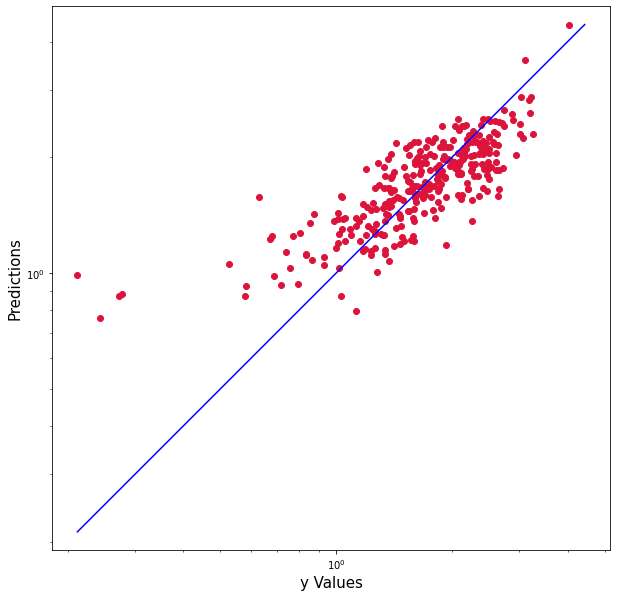

In [90]:
y_pred=svr_linear_grid.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 3.6 SVR à noyau

In [91]:
svr_kernel_parameters={
    'C':np.logspace(-2, 3, 6),
    'gamma':np.logspace(-2, 1, 4),
    'kernel':['rbf','linear'],   #,'poly','sigmoid'
    
}

In [92]:
svr_kernel_grid=gridCV(SVR(),svr_kernel_parameters,X_train,y_train,5)

Durée d'exécution de gridCV: 1705.3485383987427s


In [93]:
optimi_svr_kernel=resultats_grid(svr_kernel_grid,'KernelSVR',X_train,y_train)
optimisation=pd.concat([optimisation,optimi_svr_kernel],ignore_index=True)

Durée d'exécution de resultats_grid: 0.09752178192138672s


In [94]:
optimisation.style.hide_index()

modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
Linear regression,0.006460,0.003790,0.523593,0.537759,{'fit_intercept': True},0.388209
ElasticNet,0.005324,0.002250,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
RandomForest,4.756468,0.149120,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.129093
BaggingRegressor,0.469610,0.010171,0.135374,0.351378,"{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}",0.191544
LinearSVR,0.012056,0.003341,0.834423,0.840126,"{'C': 1.0, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive'}",0.388254
KernelSVR,7.014006,0.019667,0.336576,0.454748,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.295453


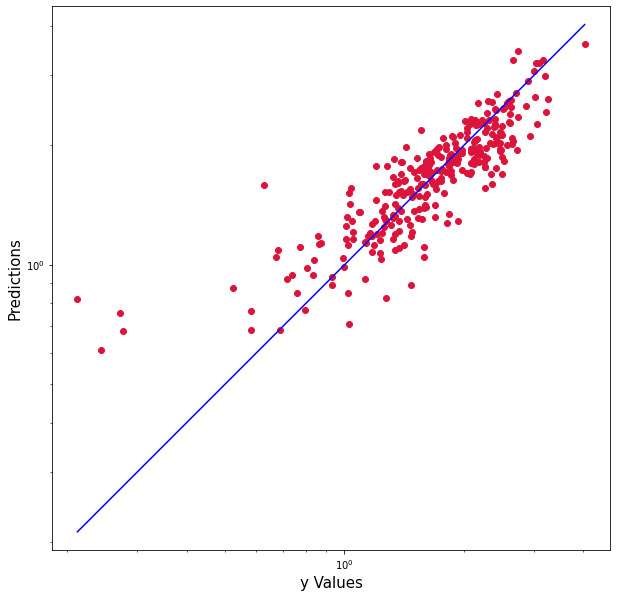

In [95]:
y_pred=svr_kernel_grid.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 3.7 Gradient Boosting

In [96]:
Grad_Boosting_parameters = {
    'loss': ['ls', 'lad','huber','quantile'],
    'learning_rate': [0.05,0.1, 0.2,0.3],
    'max_depth': [2,3,4,5]
} 

In [97]:
gb_grid = gridCV(GradientBoostingRegressor(), Grad_Boosting_parameters,X_train, y_train,5)

Durée d'exécution de gridCV: 99.73634243011475s


In [98]:
optimi_gb=resultats_grid(gb_grid,'GradientBoostingRegressor',X_train,y_train)
optimisation=pd.concat([optimisation,optimi_gb],ignore_index=True)

Durée d'exécution de resultats_grid: 0.01676344871520996s


In [99]:
optimisation.style.hide_index()

modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
Linear regression,0.006460,0.003790,0.523593,0.537759,{'fit_intercept': True},0.388209
ElasticNet,0.005324,0.002250,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
RandomForest,4.756468,0.149120,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.129093
BaggingRegressor,0.469610,0.010171,0.135374,0.351378,"{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}",0.191544
LinearSVR,0.012056,0.003341,0.834423,0.840126,"{'C': 1.0, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive'}",0.388254
KernelSVR,7.014006,0.019667,0.336576,0.454748,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.295453
GradientBoostingRegressor,0.306326,0.001022,0.349690,0.423305,"{'learning_rate': 0.2, 'loss': 'huber', 'max_depth': 3}",0.209900


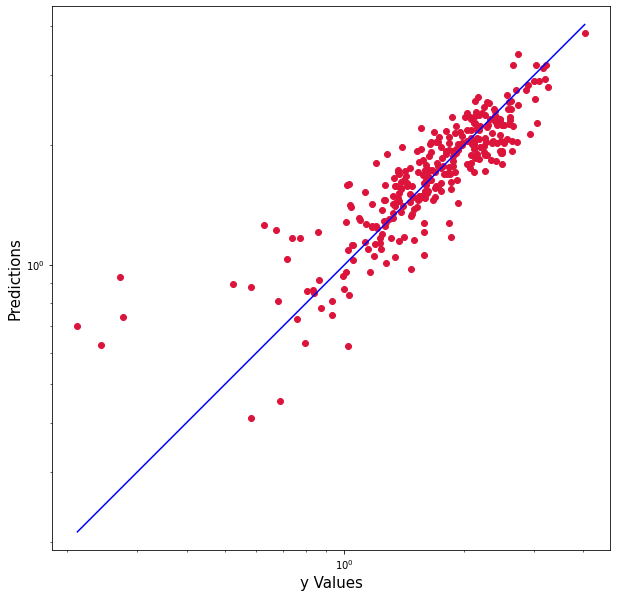

In [100]:
y_pred=gb_grid.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 3.8 KNN

In [101]:
knn_parameters = {
    'n_neighbors': np.arange(2,20,1)   
} 

In [102]:
knn_grid = gridCV(KNeighborsRegressor(),knn_parameters,X_train, y_train,5)

Durée d'exécution de gridCV: 4.440535545349121s


In [103]:
optimi_knn=resultats_grid(knn_grid,'KNeighborsRegressor',X_train,y_train)
optimisation=pd.concat([optimisation,optimi_knn],ignore_index=True)
optimisation.style.hide_index()

Durée d'exécution de resultats_grid: 0.03014373779296875s


modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
Linear regression,0.006460,0.003790,0.523593,0.537759,{'fit_intercept': True},0.388209
ElasticNet,0.005324,0.002250,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
RandomForest,4.756468,0.149120,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.129093
BaggingRegressor,0.469610,0.010171,0.135374,0.351378,"{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}",0.191544
LinearSVR,0.012056,0.003341,0.834423,0.840126,"{'C': 1.0, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive'}",0.388254
KernelSVR,7.014006,0.019667,0.336576,0.454748,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.295453
GradientBoostingRegressor,0.306326,0.001022,0.349690,0.423305,"{'learning_rate': 0.2, 'loss': 'huber', 'max_depth': 3}",0.209900
KNeighborsRegressor,0.002413,0.021073,0.357823,0.414956,{'n_neighbors': 9},0.359801


In [104]:
#instanciation et définition du k
K = [] 
training = [] 
test = [] 
scores = {} 
  
for k in range(2, 20): 
    knn = KNeighborsRegressor(n_neighbors = k) 
    knn.fit(X_train,y_train)
    training_score = knn.score(X_train,y_train) 
    test_score = knn.score(X_test, y_test) 
    K.append(k) 
  
    training.append(training_score) 
    test.append(test_score) 
    scores[k] = [training_score, test_score] 
    

In [105]:
for keys, values in scores.items(): 
    print(keys, ':', values)

2 : [0.843721967479193, 0.5188924517740268]
3 : [0.7841191989196454, 0.5394393197133248]
4 : [0.7434046407170007, 0.5668034850490995]
5 : [0.7168557969801023, 0.5929622783641764]
6 : [0.7013755447082576, 0.6006675354405371]
7 : [0.6939492906876026, 0.6023865409119575]
8 : [0.6842503495067151, 0.5958066082021992]
9 : [0.6745934704995977, 0.5974786165526731]
10 : [0.6675615608334811, 0.5991108316377596]
11 : [0.6621208836729251, 0.5921108722622729]
12 : [0.6572726487533165, 0.594892415750853]
13 : [0.6532841875135559, 0.6009916645240174]
14 : [0.6468461236102466, 0.5995545041202072]
15 : [0.6388367864272312, 0.6012705858144514]
16 : [0.6355602282733158, 0.597173251030058]
17 : [0.6324522973953868, 0.5975607097073073]
18 : [0.6310670006419262, 0.5951748705934856]
19 : [0.6266263044872562, 0.5938239934922722]


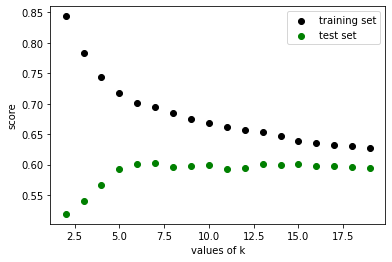

In [106]:
#for keys, values in scores.items():
    #print(keys, ':', values)
plt.scatter(K, training, color ='k',label="training set") 
plt.scatter(K, test, color ='g',label='test set')
plt.xlabel('values of k')
plt.ylabel('score')
plt.legend()
plt.show() 

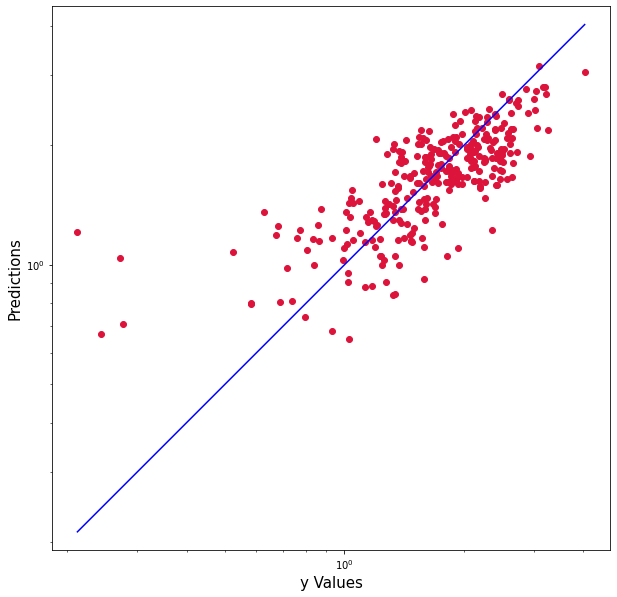

In [107]:
y_pred=knn_grid.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [108]:
@timeit
def affiche_modelisations(data, name):
    x = np.arange(len(data.index))
    width = 0.35

    fig, ax = plt.subplots(2,1,figsize=(20,12), sharey=False, sharex=False)

    scores1 = ax[0].bar(x - width/2, data['Mean train score RMSE'], width, label='Train')
    scores2 = ax[0].bar(x + width/2, data['Mean test score RMSE'], width, label='Test')
    ax[0].set_ylabel('Root Mean Squared Error')
    ax[0].set_title('Comparaison des scores sur le train et le test set par modèle')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(data['modèle'])
    ax[0].legend()
    ax[0].bar_label(scores1, padding=3)
    ax[0].bar_label(scores2, padding=3)

    times1 = ax[1].bar(x - width/2, data['Fit time'], width, label='fit time')
    times2 = ax[1].bar(x + width/2, data['Score time'], width, label='score time')
    ax[1].set_ylabel('temps(s)')
    ax[1].set_title("Comparaison des temps d'entrainement et de prédiction")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(data['modèle'])
    ax[1].legend()
    ax[1].bar_label(times1, padding=3, fmt='%.3f')
    ax[1].bar_label(times2, padding=3, fmt='%.3f')

    plt.suptitle(f"Modélisations pour la cible {name} ", fontsize=22)
    fig.tight_layout()

    plt.show()

##  4. Comparaison des modèles

### 4.1 Graphiques comparatifs des RMSE et des temps d'exécution.

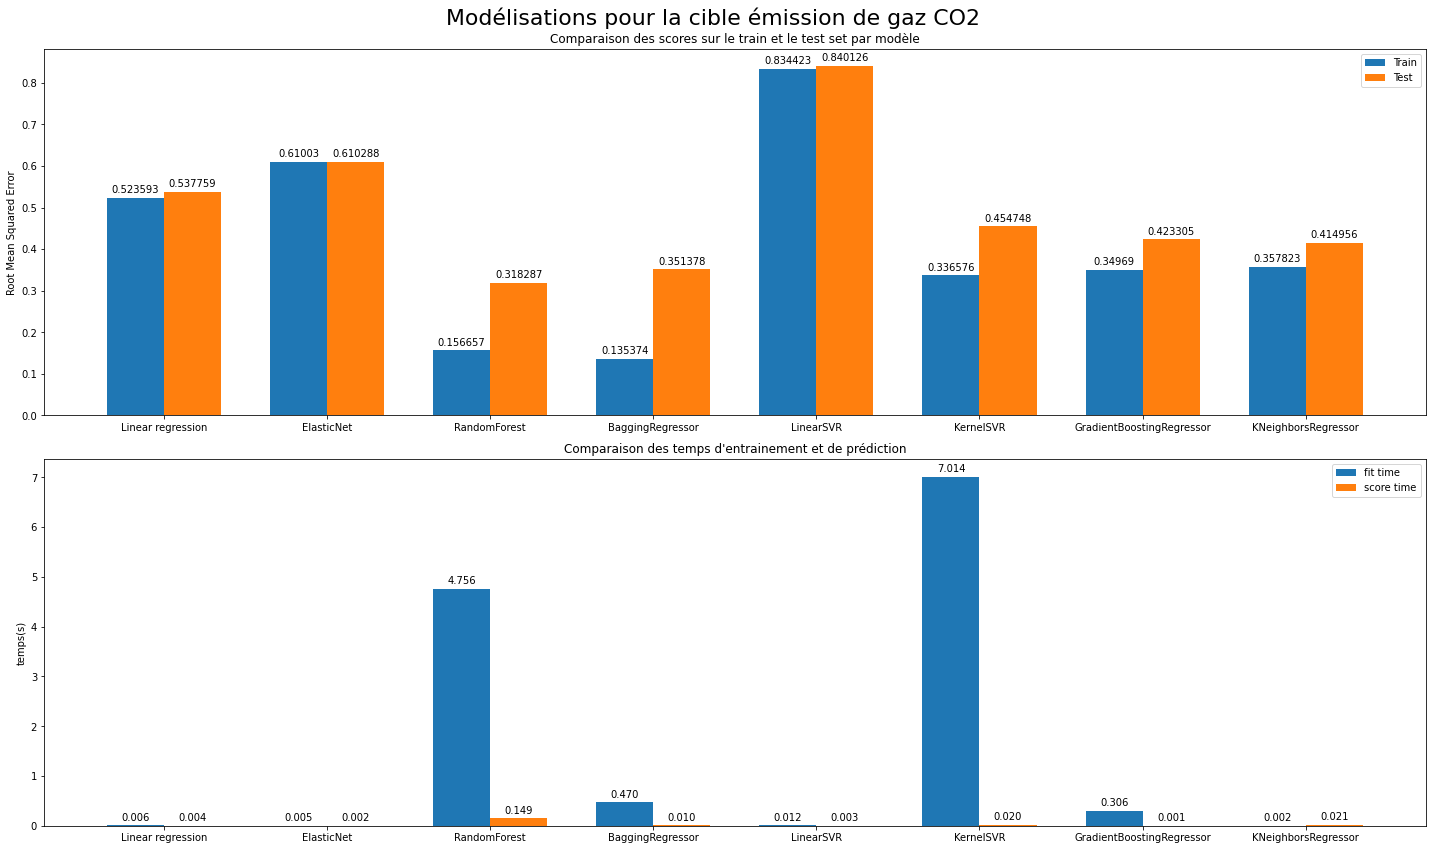

Durée d'exécution de affiche_modelisations: 0.6092329025268555s


In [109]:
affiche_modelisations(optimisation, "émission de gaz CO2")

In [110]:
rf_conso_best = rf_grid.best_estimator_
print(rf_conso_best)
print(rf_grid.best_score_)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=3,
                      n_estimators=1400)
-0.31688934104846056


### 4.2 Importance des variables

In [111]:
# Affichage des features importance
def affic_features_importance_model(model,  X_test, name):
    
    feat_imp = model.feature_importances_
    df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
    df_featimp["Feature Name"] = X_test.columns
    df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=True)
    display(df_featimp)
    
    # Affichage Features importance
    plt.figure(figsize=(10,7))
    plt.barh(df_featimp["Feature Name"], df_featimp["Feature Importance"])
    plt.xlabel("Feature Importance")
    plt.title(f"Feature importance pour le modele {name} ")
    plt.show()

    return None

,Feature Importance,Feature Name
17,0.002595,Neighborhood_LAKE UNION
18,0.003068,Neighborhood_MAGNOLIA / QUEEN ANNE
22,0.003360,SecondLargestPropertyUseType_Office
24,0.003566,ThirdLargestPropertyUseType_0
15,0.006067,Neighborhood_DOWNTOWN
21,0.006311,SecondLargestPropertyUseType_0
16,0.006562,Neighborhood_GREATER DUWAMISH
20,0.007538,LargestPropertyUseType_Office
12,0.007555,PrimaryPropertyType_Other
23,0.008712,SecondLargestPropertyUseType_Parking


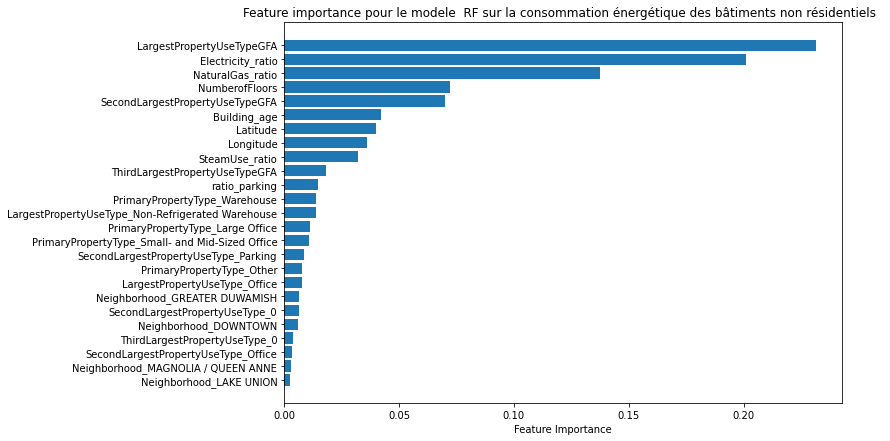

In [112]:
affic_features_importance_model(rf_conso_best, X_test," RF sur la consommation énergétique des bâtiments non résidentiels ")

## 5. Intêret de l' ENERGYStarScore 

Au préalable , nous chargeons le fichier csv contenant les données du EnergyStarScore et nous allons entrainer notre modèle avec les nouvelles données

In [113]:
path =('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P4\\cleaned\\')
filename='df_en_star_p4.csv'  

In [114]:
data_=pd.read_csv(path+filename)

In [115]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     987 non-null    object 
 1   PrimaryPropertyType              987 non-null    object 
 2   Neighborhood                     987 non-null    object 
 3   Latitude                         987 non-null    float64
 4   Longitude                        987 non-null    float64
 5   NumberofFloors                   987 non-null    int64  
 6   LargestPropertyUseType           987 non-null    object 
 7   LargestPropertyUseTypeGFA        987 non-null    float64
 8   SecondLargestPropertyUseType     987 non-null    object 
 9   SecondLargestPropertyUseTypeGFA  987 non-null    float64
 10  ThirdLargestPropertyUseType      987 non-null    object 
 11  ThirdLargestPropertyUseTypeGFA   987 non-null    float64
 12  ENERGYSTARScore       

Retirons les variables 'log_consommation'

In [116]:
data_.drop(columns=['log_consommation'],inplace=True)

### 5.1.1 X et y

In [117]:
seed=1234
X=data_.drop(columns=['log_emission'])
y=data_.log_emission

### 5.1.2 Preprocessing des variables du jeu de données avec transformers ScandardScaler et OneHotEncoder

In [118]:
set_config(transform_output="pandas")

# on définit les colonnes et les transformations pour les colonnes quantitatives

col_quanti =  X.select_dtypes(['int64','float64']).columns

transfo_quanti = Pipeline(steps=[('standard', StandardScaler())])

# on définit les colonnes et les transformations pour les variables qualitatives

col_quali =  X.select_dtypes(['object']).columns

transfo_quali = Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False,drop="if_binary", handle_unknown="ignore"))])

# on définit l'objet de la classe ColumnTransformer qui va permettre  d'appliquer toutes les étapes

traitement = ColumnTransformer(
    transformers=[
        ('quanti', transfo_quanti , col_quanti),
        ('quali', transfo_quali , col_quali)])

### 5.1.3 Création du pipeline et entrainement du modèle avec une RandomForestRegression

In [119]:
# on crée un pipeline  intégrant la préparation
modele_ml_ = Pipeline(steps=[('preprocessing', traitement),
                      ('rf', RandomForestRegressor(n_estimators=100, 
                                      random_state=seed, 
                                      verbose=0))])

# on construit les jeux d'entrainement , de test et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.20,random_state=seed)

# on ajuste le modèle en utilisant les données d'apprentissage
# le modèle comporte la préparation et le modèle logistique
modele_ml_.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quanti',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  Index(['Latitude', 'Longitude', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'ratio_parking', 'Building_age', 'SteamUse_ratio',
       'Electricity_ratio'...o'],
      dtype='object')),
                                                 ('quali',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType'],
      dtype='object'))])),
                ('rf', RandomForestRegressor(random_state=1234))])

In [120]:
# afficher les scores du modele
score(modele_ml_)

score train : 0.9775 score_test : 0.8835 


### 5.1.4 Recherche des meilleurs paramètres avec GridSearchCV

In [121]:
# on définit les paramètres à faire varier
param_grid = {
    'rf__n_estimators': [150,250,300],
'rf__max_features':["sqrt","log2","None"],
'rf__max_depth':[None,1],
'rf__max_leaf_nodes': [None,2]}

# on crée le modèle de grille
grid_search_ = GridSearchCV(modele_ml_, param_grid, cv=5)
# on ajuste aux données d'apprentissage
grid_search_.fit(X_train, y_train)


print(("Le meilleur modèle logistique a obtenu sur les données test la performance suivante : %.2f"
       % grid_search_.score(X_test, y_test)))
print('les meilleurs paramètres sont :',grid_search_.best_params_)

Le meilleur modèle logistique a obtenu sur les données test la performance suivante : 0.84
les meilleurs paramètres sont : {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': None, 'rf__n_estimators': 300}


> On va entrainer le modèle avec les meilleurs hyper-paramètres

In [122]:
modele_ml_ = Pipeline(steps=[('preprocessing', traitement),
                      ('rf', RandomForestRegressor(max_depth= None, max_features= 'sqrt', max_leaf_nodes= None,
                                                   n_estimators= 300
                                                  ,random_state=seed, 
                                                  verbose=0))])


# on ajuste le modèle en utilisant les données d'apprentissage

modele_ml_.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quanti',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  Index(['Latitude', 'Longitude', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'ratio_parking', 'Building_age', 'SteamUse_ratio',
       'Electricity_ratio'...
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType'],
      dtype='object'))])),
                ('rf',
                 RandomForestRegressor(max_features='sqrt', n_estimators=300,
                                       random_state=1234))])

In [123]:
y_pred=modele_ml_.predict(X_test)

In [124]:
score(modele_ml_)

score train : 0.9748 score_test : 0.8363 


> nous n'avons pas amélioré les performances du modèle :  

        avant tuning des hyper-paramètres :    score train : 0.9775 et score_test : 0.8835
        après tuning des hyper-paramètres :    score train : 0.9746 et score_test : 0.8342         

### 5.1.5 Importance des variables du dataset dans la regression RF

In [125]:
#  poids des variables de la regression RF à partir du modele pipeline
reg_rf_ = modele_ml_[-1]
# crée un dataframe pandas
data = list(zip(reg_rf_.feature_names_in_, reg_rf_.feature_importances_*100))
df_importances_ = pd.DataFrame(data, columns=['Feature', '% Importance']).sort_values(by='% Importance', ascending=True)
df_importances_.tail(20)

,Feature,% Importance
18,quali__PrimaryPropertyType_Hotel,1.021779
54,quali__LargestPropertyUseType_Hospital (Genera...,1.064750
68,quali__LargestPropertyUseType_Supermarket/Groc...,1.116772
29,quali__PrimaryPropertyType_Supermarket / Groce...,1.243783
5,quanti__ThirdLargestPropertyUseTypeGFA,1.422276
7,quanti__ratio_parking,1.495580
59,quali__LargestPropertyUseType_Non-Refrigerated...,1.737200
30,quali__PrimaryPropertyType_Warehouse,1.742244
20,quali__PrimaryPropertyType_Large Office,1.793924
28,quali__PrimaryPropertyType_Small- and Mid-Size...,2.428424


<Axes: ylabel='Feature'>

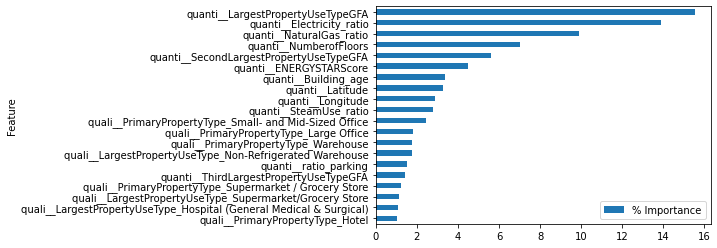

In [126]:
df_importances_.tail(20).plot.barh(x='Feature', y='% Importance')

### 5.1.6 Sélection des variables avec le transformer VarianceThresold (seuil de variance minimale en dessous duquel les variables ne sont pas conservées)

In [127]:
X[col_quanti] = transfo_quanti.fit_transform(X[col_quanti])
ohe=transfo_quali.fit_transform(X[col_quali])

In [128]:
X = pd.merge(X[col_quanti], 
          pd.DataFrame(columns = transfo_quali.get_feature_names_out().tolist(),
              data =ohe),
        left_index = True, right_index = True)

Eliminons les variables qui ont une variance inférieure au seuil fixé (seuil fixé = mean )

In [129]:
# on crée le selector
selector = VarianceThreshold(threshold =X.var(axis=0).mean())

#on entraine et transforme
X_thres=selector.fit_transform(X)


In [130]:
concol = [column for column in X.columns 
          if column not in X.columns[selector.get_support()]]

for features in concol:
    print(features)
print('nombre de colonnes:',len(concol))

BuildingType_Campus
BuildingType_NonResidential
BuildingType_Nonresidential COS
BuildingType_SPS-District K-12
PrimaryPropertyType_Distribution Center
PrimaryPropertyType_Hospital
PrimaryPropertyType_Hotel
PrimaryPropertyType_K-12 School
PrimaryPropertyType_Medical Office
PrimaryPropertyType_Mixed Use Property
PrimaryPropertyType_Other
PrimaryPropertyType_Refrigerated Warehouse
PrimaryPropertyType_Residence Hall
PrimaryPropertyType_Retail Store
PrimaryPropertyType_Senior Care Community
PrimaryPropertyType_Supermarket / Grocery Store
PrimaryPropertyType_Worship Facility
Neighborhood_BALLARD
Neighborhood_Ballard
Neighborhood_CENTRAL
Neighborhood_Central
Neighborhood_DELRIDGE
Neighborhood_Delridge
Neighborhood_EAST
Neighborhood_LAKE UNION
Neighborhood_MAGNOLIA / QUEEN ANNE
Neighborhood_NORTH
Neighborhood_NORTHEAST
Neighborhood_NORTHWEST
Neighborhood_North
Neighborhood_Northwest
Neighborhood_SOUTHEAST
Neighborhood_SOUTHWEST
LargestPropertyUseType_Bank Branch
LargestPropertyUseType_Courthou

In [131]:
X=X.drop(concol,axis=1)

In [132]:
X.shape

(987, 22)

## 5.2 découpage de dataset avec le transformer Test_train_split

In [133]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.20,
                                                random_state=seed)

In [134]:
print(f"nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
      

nous avons X_train de forme (789, 22) et y_train de forme (789,)
Nous avons X_test de forme (198, 22) et y_test de forme (198,)


## 5.3 Entrainement du meilleur modèle avec le data set "Energy Star Score"

In [135]:
rf_grid_star = gridCV(RandomForestRegressor(), random_parameters,X_train, y_train,5)

Durée d'exécution de gridCV: 459.25551438331604s


## 5.4 Comparaison des résultats

In [136]:
optimisation_star=resultats_grid(rf_grid_star,'RandomForest',X_train,y_train)
optimisation_star.style.hide_index()

Durée d'exécution de resultats_grid: 0.22195839881896973s


modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
RandomForest,3.075606,0.117546,0.135487,0.278278,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.110516


In [137]:
# pour comparaison les résultats sans la variable EnergyStar
optimisation.style.hide_index()

modèle,Fit time,Score time,Mean train score RMSE,Mean test score RMSE,Best estimator,RMSE best estimator
Linear regression,0.006460,0.003790,0.523593,0.537759,{'fit_intercept': True},0.388209
ElasticNet,0.005324,0.002250,0.610030,0.610288,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.388506
RandomForest,4.756468,0.149120,0.156657,0.318287,"{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1400}",0.129093
BaggingRegressor,0.469610,0.010171,0.135374,0.351378,"{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}",0.191544
LinearSVR,0.012056,0.003341,0.834423,0.840126,"{'C': 1.0, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive'}",0.388254
KernelSVR,7.014006,0.019667,0.336576,0.454748,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.295453
GradientBoostingRegressor,0.306326,0.001022,0.349690,0.423305,"{'learning_rate': 0.2, 'loss': 'huber', 'max_depth': 3}",0.209900
KNeighborsRegressor,0.002413,0.021073,0.357823,0.414956,{'n_neighbors': 9},0.359801


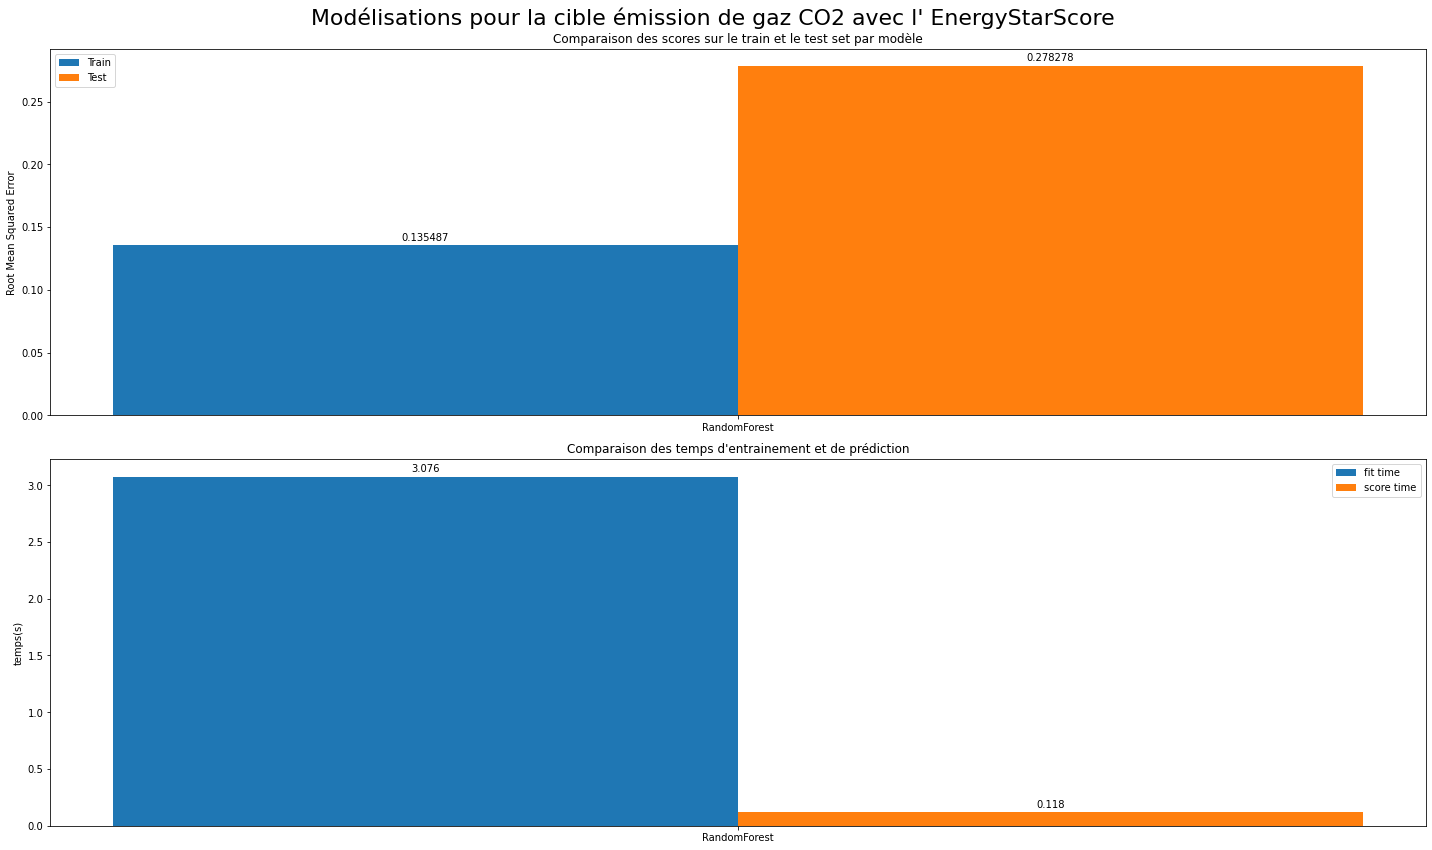

Durée d'exécution de affiche_modelisations: 0.33237338066101074s


In [138]:
affiche_modelisations(optimisation_star, "émission de gaz CO2 avec l' EnergyStarScore")

L'utilisation de l'EnergyStarScore a augmenté très légèrement les performances du modèle de prédiction des émissions de gaz CO2
Toutefois son coût et le peu de données disponibles ne plaident pas en sa faveur pour une utilisation future.

D'autres pistes peuvent être exploitées pour améliorer les performances du modèle:

- une mise à disposition d’une plus grande quantité de données
- une feature engineering plus poussé
-  une gestion différente des valeurs manquantes et outliers 
- une sélection préalable des variables basée sur la feature importance  
- l’emploi de sélecteurs récursifs et transformers de feature selection dans la Pipeline